In [40]:
# import libraries
import pandas as pd
import numpy  as np
import hvplot.pandas
import yfinance as yf
import quantstats as qs
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import ta
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime, timedelta
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Set variables
start_date = '2020-01-01'
end_date = '2024-03-17'
window = 14
long_window = 35

In [41]:
# Get stock data
stock_data = yf.download('SPY', interval='1D', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [42]:
# Pull relevant info out
trading_df = stock_data.loc[:,["Close"]]
trading_df['SMA'] = trading_df['Close'].rolling(window=window).mean()
trading_df['LMA'] = trading_df['Close'].rolling(window=long_window).mean()
trading_df['Signal'] = 0.0
trading_df['Signal'][window:] = np.where(
    trading_df['Close'][window:] > trading_df['SMA'][window:], 1.0, 2.0
)
trading_df['Entry/Exit'] = trading_df['Signal'].diff()
trading_df = trading_df.dropna()

# Use the pct_change function to generate returns from close prices
trading_df["Actual Returns"] = trading_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

display(trading_df.head())
display(trading_df.tail())

,Close,SMA,LMA,Signal,Entry/Exit,Actual Returns
Date,,,,,,
2020-02-24,322.420013,334.145719,329.821718,2.0,0.0,-0.033165
2020-02-25,312.649994,332.973576,329.542861,2.0,0.0,-0.030302
2020-02-26,311.500000,331.447863,329.196003,2.0,0.0,-0.003678
2020-02-27,297.510010,328.842863,328.475432,2.0,0.0,-0.044912
2020-02-28,296.260010,326.275720,327.670003,2.0,0.0,-0.004202


,Close,SMA,LMA,Signal,Entry/Exit,Actual Returns
Date,,,,,,
2024-03-11,511.279999,508.550709,499.242858,1.0,0.0,-0.000860
2024-03-12,516.780029,509.948569,500.195144,1.0,0.0,0.010757
2024-03-13,515.969971,510.553567,501.084001,1.0,0.0,-0.001568
2024-03-14,514.950012,511.060710,501.928572,1.0,0.0,-0.001977
2024-03-15,509.829987,511.334996,502.551429,2.0,1.0,-0.009943


In [43]:
# plot sma and price

close = trading_df['Close'].hvplot(
    line_color='orange',
    ylabel='SPY Price Chart',
    xlabel='Date',
    width=1000,
    height=400
)

sma = trading_df['SMA'].hvplot(
    line_color='blue',
    ylabel = 'SMA',
    xlabel='Date',
    width = 1000,
    height = 400 
)

lma = trading_df['LMA'].hvplot(
    line_color = 'purple',
    ylabel = 'LMA',
    xlabel='Date',
    width=1000,
    height=400
)

plot = close * sma * lma
plot.opts(
    title="SPY Price - Moving Average Strategy",
    yformatter='%.0f'
)

:Overlay
   .Curve.Close :Curve   [Date]   (Close)
   .Curve.SMA   :Curve   [Date]   (SMA)
   .Curve.LMA   :Curve   [Date]   (LMA)

In [44]:
# Backtest Lib
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, TrailingStrategy
from backtesting.test import SMA

class SmaCross(TrailingStrategy):
  
    n1= 2
    n2= 56

    def init(self):
        super().init()
        super().set_trailing_sl(1)
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        super().next()
        if crossover(self.data.Close, self.sma1):
            self.buy()
        elif crossover(self.data.Close, self.sma2):
                self.sell()

  

#Assuming you have a DataFrame named 'aapl_data' containing your data
bt = Backtest(stock_data, SmaCross, cash=10000, exclusive_orders=True)

output = bt.run()


In [45]:
output

Start                     2020-01-02 00:00:00
End                       2024-03-15 00:00:00
Duration                   1534 days 00:00:00
Exposure Time [%]                   78.355388
Equity Final [$]                 19701.164351
Equity Peak [$]                  20243.209328
Return [%]                          97.011644
Buy & Hold Return [%]               56.933541
Return (Ann.) [%]                   17.528617
Volatility (Ann.) [%]               17.827406
Sharpe Ratio                          0.98324
Sortino Ratio                        1.824056
Calmar Ratio                         1.944504
Max. Drawdown [%]                   -9.014444
Avg. Drawdown [%]                   -2.098536
Max. Drawdown Duration      180 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades                                  267
Win Rate [%]                        53.183521
Best Trade [%]                        9.35157
Worst Trade [%]                       -5.0804
Avg. Trade [%]                    

In [46]:
# Optimize Returns
#opti = bt.optimize(n1 = range(1, 200, 1),
#n2 = range(10, 200, 1),
#constraint= lambda x: x.n2 - x.n1 > 10,
#maximize = 'Return (Ann.) [%]')

#opti

In [47]:
# Begin K means

# sequentially split data
X = trading_df.drop('Entry/Exit', axis=1)  # Drop the 'Entry/Exit' column
y = trading_df['Entry/Exit']
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]


# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Import the KNeighborsClassifier module from sklearn
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training data
knn.fit(X_train_scaled, y_train)

# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

        -1.0       0.33      0.25      0.29         8
         0.0       0.93      0.98      0.95       188
         1.0       1.00      0.11      0.20         9

    accuracy                           0.91       205
   macro avg       0.75      0.45      0.48       205
weighted avg       0.91      0.91      0.89       205



In [49]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# # Add the KNN model predictions to the DataFrame
predictions_df['Predicted'] = y_pred

# # Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = trading_df['Actual Returns']

# # Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    trading_df['Actual Returns'] * predictions_df['Predicted']
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-05-23,0.0,-0.011223,-0.000000
2023-05-24,0.0,-0.007245,-0.000000
2023-05-25,0.0,0.008660,0.000000
2023-05-26,-1.0,0.012951,-0.012951
2023-05-30,0.0,0.000381,0.000000


,Predicted,Actual Returns,Strategy Returns
Date,,,
2024-03-11,0.0,-0.000860,-0.0
2024-03-12,0.0,0.010757,0.0
2024-03-13,0.0,-0.001568,-0.0
2024-03-14,0.0,-0.001977,-0.0
2024-03-15,0.0,-0.009943,-0.0


<Axes: xlabel='Date'>

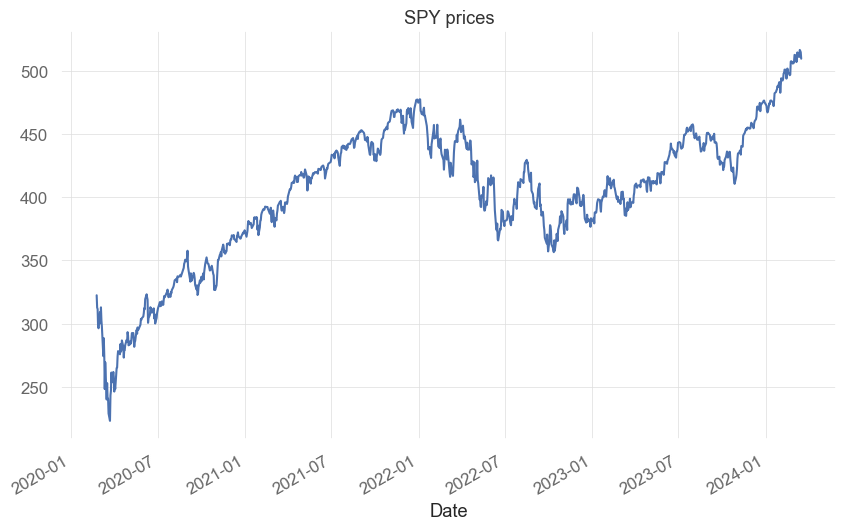

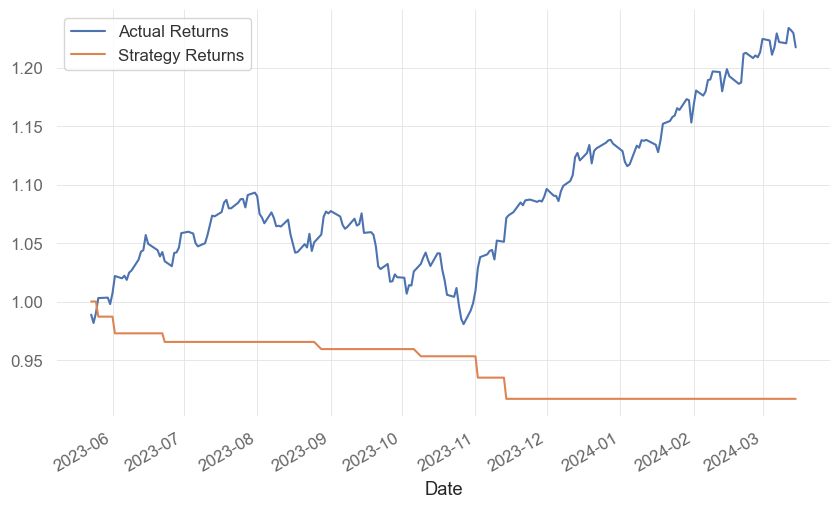

In [53]:

# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()
